In [5]:
import os
import glob
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap
import clip
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
import hdbscan

In [4]:
# 1. Load image paths and assign folder labels
base_dir = "/home/alexander/bueschelquinare_preprocessed/obverse"
image_paths = glob.glob(f"{base_dir}/*/*.png")

labels = []
label_names = []
features = []

# 2. Preprocessing and model setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = models.resnet18(pretrained=True)
#model = torch.nn.Sequential(*list(model.children())[:-1])  # remove classifier
#model.eval().to(device)


model, preprocess = clip.load("ViT-B/32", device=device)

# 3. Feature extraction loop
for path in image_paths:
    try:
        #img = Image.open(path).convert("RGB")
        #x = transform(img).unsqueeze(0).to(device)
        #with torch.no_grad():
        #    feat = model(x).squeeze().cpu().numpy()  # 512D
        img = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model.encode_image(img).squeeze().cpu().numpy()

        features.append(feat)

        # Extract label (A, B, C, etc.) from folder
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)

    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)



100%|███████████████████████████████████████| 338M/338M [00:28<00:00, 12.6MiB/s]


# RESNET18 with k means and UMAP

/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved feature data to coin_features_pca.pkl


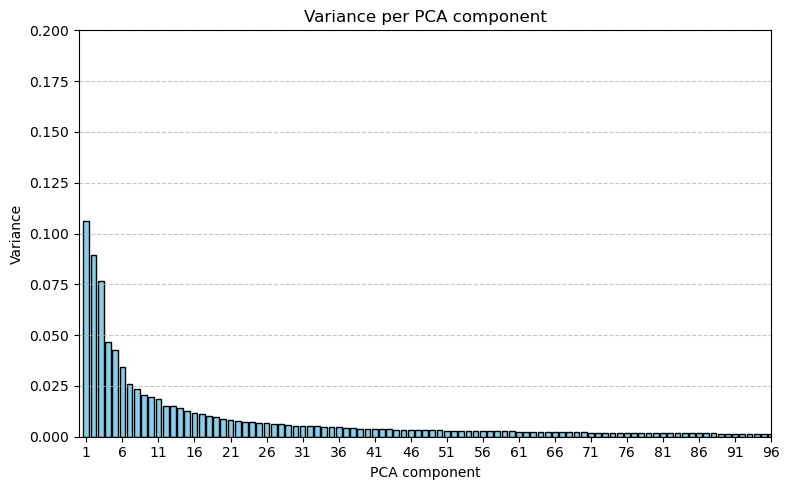

Silhouette Score (KMeans): 0.071
Running UMAP...


/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


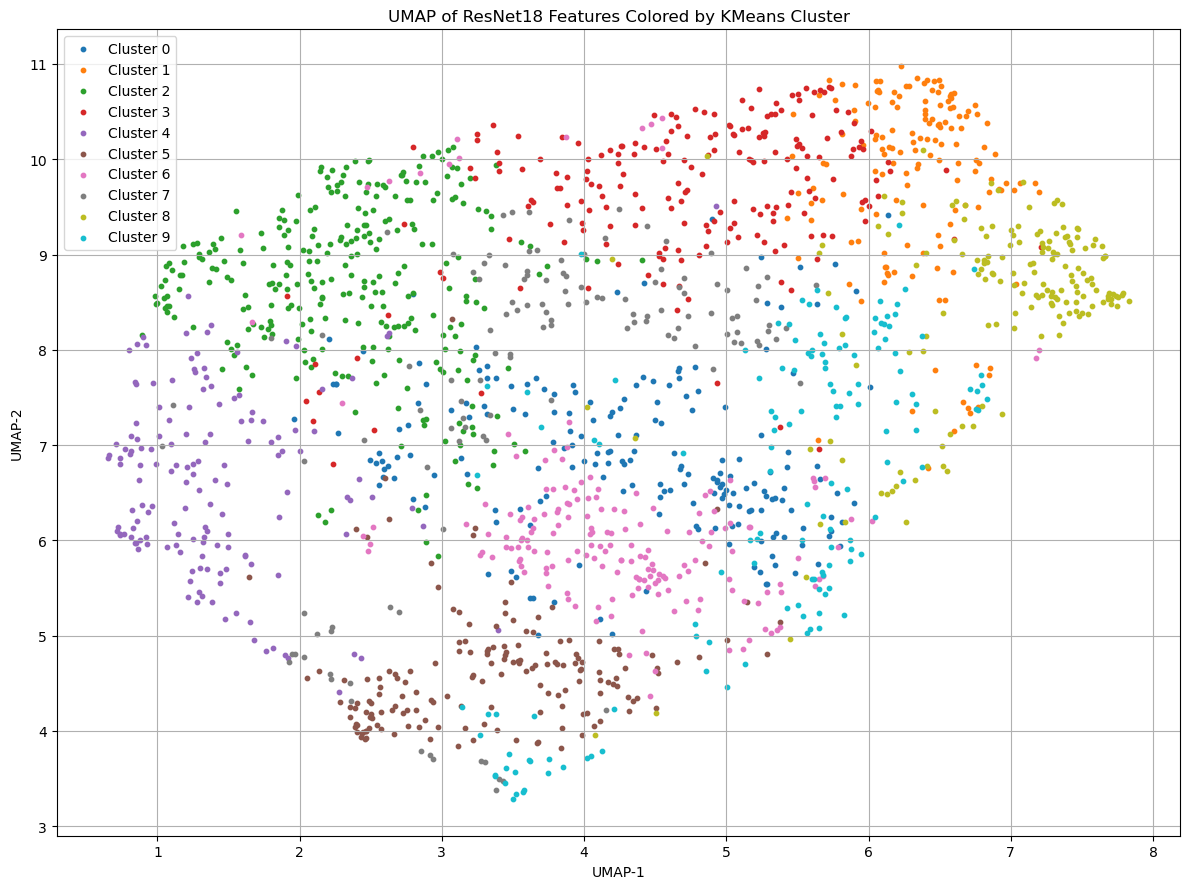

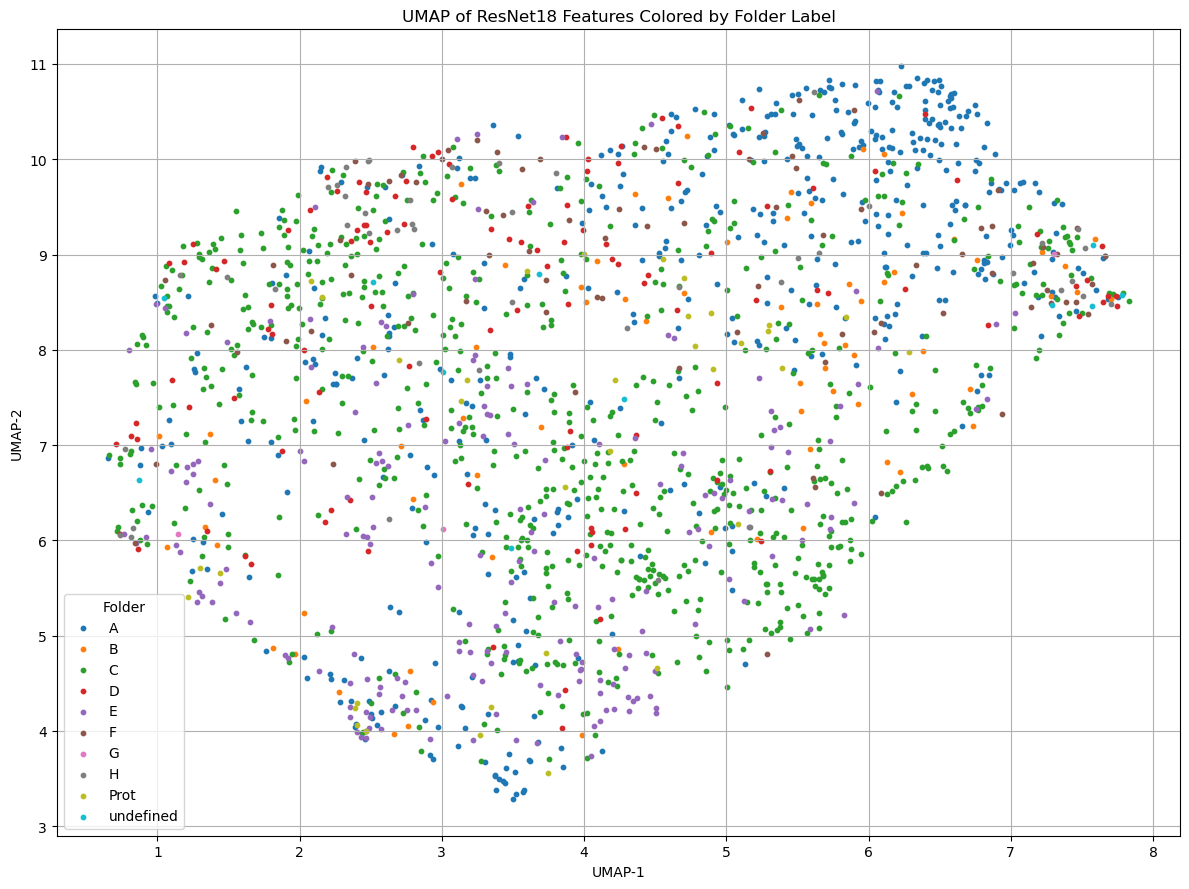

In [19]:
import os
import glob
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Load image paths
base_dir = "/home/alexander/bueschelquinare_preprocessed/obverse"
image_paths = glob.glob(f"{base_dir}/*/*.png")

labels = []
features = []

# 2. Preprocessing and model setup
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove classifier
model.eval().to(device)

# 3. Extract features
for path in image_paths:
    try:
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(x).squeeze().cpu().numpy()  # shape: (512,)
        features.append(feat)

        label = os.path.basename(os.path.dirname(path))  # folder name
        labels.append(label)
    except Exception as e:
        print(f"Error with {path}: {e}")

features = np.array(features)

#normalisze
scaler = StandardScaler()
feature_vector = scaler.fit_transform(features)
#PCA
pca = PCA(n_components = 100)
reduced = pca.fit_transform(feature_vector)
explained_variance = pca.explained_variance_ratio_

import pickle

# File path to save
save_path = "coin_features_pca.pkl"

# Save features, labels, group names
with open(save_path, "wb") as f:
    pickle.dump({
        "features": reduced,         # PCA-reduced features
        "labels": labels,            # folder-based labels
        "group_names": np.unique(labels).tolist()  # optional
    }, f)

print(f"Saved feature data to {save_path}")


plt.figure(figsize=(8, 5))
components = np.arange(1, len(explained_variance) + 1)
plt.bar(components, explained_variance, color='skyblue', edgecolor='black')
plt.xlabel('PCA component')
plt.ylabel('Variance')
plt.xlim(0,11)
plt.title('Variance per PCA component')
plt.xticks(components[::5])
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("variance_pca.png")
plt.show()

# 4. KMeans clustering (optional)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

sil_score = silhouette_score(features, cluster_labels)
print(f"Silhouette Score (KMeans): {sil_score:.3f}")

# 5. UMAP dimensionality reduction
print("Running UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(features)

# 6A. Plot by KMeans cluster
plt.figure(figsize=(12, 9))
for i in range(n_clusters):
    idxs = np.where(cluster_labels == i)[0]
    plt.scatter(embedding[idxs, 0], embedding[idxs, 1], label=f"Cluster {i}", s=10)
plt.title("UMAP of ResNet18 Features Colored by KMeans Cluster")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6B. (Alternative) Plot by true folder label
# Label encoding
le = LabelEncoder()
label_ids = le.fit_transform(labels)
unique_labels = le.classes_

plt.figure(figsize=(12, 9))
for i, label in enumerate(unique_labels):
    idxs = np.where(label_ids == i)[0]
    plt.scatter(embedding[idxs, 0], embedding[idxs, 1], label=label, s=10)
plt.title("UMAP of ResNet18 Features Colored by Folder Label")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Folder")
plt.grid(True)
plt.tight_layout()
plt.show()


# Pyro HDP-HSMM-Like Code

[0] ELBO: 2580060961.40
[500] ELBO: 67906847.81
[1000] ELBO: 421446000.99
[1500] ELBO: 214848932.85
[2000] ELBO: 116334867.45
[2500] ELBO: 15020613.30


/tmp/ipykernel_5986/884198460.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(group_data))


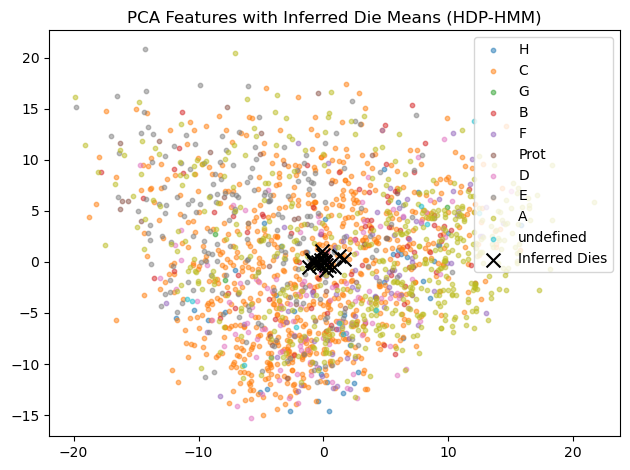

In [18]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Setup
pyro.clear_param_store()
torch.manual_seed(0)
device = torch.device("cpu")

# Configuration
num_states = 20         # Truncation level (max dies)
#obs_dim = 2             # Coin feature dimension (e.g., PCA/CNN-reduced)
obs_dim = reduced.shape[1]  # Use 100 if that's your PCA dim

# Simulate toy coin group data (replace with your own features)
def simulate_group(lengths, means):
    return [torch.distributions.MultivariateNormal(torch.tensor(mu, dtype=torch.float32), torch.eye(obs_dim)).sample((n,))
            for n, mu in zip(lengths, means)]

from collections import defaultdict

# Group reduced features by label
grouped_features = defaultdict(list)
for feat, label in zip(reduced, labels):
    grouped_features[label].append(feat)

# Convert grouped lists to float32 torch tensors
group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
group_names = list(grouped_features.keys())  # Keep track of group names


# EXAMPLE DATA
#group_data = [
#    torch.cat(simulate_group([10, 15, 10], [[0, 0], [5, 5], [0, 0]])),
#    torch.cat(simulate_group([20, 10], [[5, 5], [8, -2]])),
#    torch.cat(simulate_group([12, 18], [[0, 0], [8, -2]]))
#]

# Ensure all are float32
#group_data = [seq.float() for seq in group_data]

# --- HDP Mixture Model (simplified HDP-HMM) ---
def model(groups):
    beta_k = pyro.sample("beta_k", dist.Beta(1., 1.).expand([num_states]).to_event(1))

    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

    mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

    for g, seq in enumerate(groups):
        pi = pyro.sample(f"pi_{g}", dist.Dirichlet(beta[:-1] + 0.1))

        with pyro.plate(f"obs_{g}", seq.shape[0]):
            z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
            pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

# --- Guide (variational posterior) ---
def guide(groups):
    beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
    pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

    mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
    mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

    sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

    for g in range(len(groups)):
        alpha = pyro.param(f"alpha_{g}", lambda: torch.ones(num_states), constraint=dist.constraints.positive)
        pyro.sample(f"pi_{g}", dist.Dirichlet(alpha))

# --- Training ---
#optimizer = Adam({"lr": 0.01})
#svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

#num_steps = 3000
#for step in range(num_steps):
#    loss = svi.step(group_data)
#    if step % 500 == 0:
#        print(f"[{step}] ELBO: {loss:.2f}")

# Start the HDP-HMM model training
svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

num_steps = 3000
for step in range(num_steps):
    loss = svi.step(group_data)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")


# --- Posterior Visualization ---
#mus_post = pyro.param("mus_loc").detach()
#colors = ['red', 'blue', 'green']

#for i, seq in enumerate(group_data):
#    plt.scatter(seq[:, 0], seq[:, 1], color=colors[i], alpha=0.5, label=f'Group {i+1}')

#plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
#plt.title("Coin Feature Space with Inferred Die Means")
#plt.legend()
#plt.xlabel("Feature 1")
#plt.ylabel("Feature 2")
#plt.tight_layout()
#plt.show()

# Inferred die (state) locations
mus_post = pyro.param("mus_loc").detach().cpu()
colors = plt.cm.get_cmap('tab10', len(group_data))

# Plot group PCA features
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, alpha=0.5, s=10, color=colors(i))

# Plot inferred die means
plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
plt.title("PCA Features with Inferred Die Means (HDP-HMM)")
plt.legend()
plt.tight_layout()
plt.show()


# Visualization with hover and image display using Bokeh

In [10]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category20, turbo
from PIL import Image
from io import BytesIO
import base64
import os
import numpy as np

# Convert image to base64 thumbnail
def image_to_base64(path):
    img = Image.open(path).convert("RGB")
    img.thumbnail((128, 128))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()

# Inputs
# - image_paths: list of paths to coin images
# - labels: list of folder labels (e.g. os.path.basename(os.path.dirname(path)))
# - embedding: np.array of shape (n_samples, 2), from UMAP

# Generate thumbnails
thumbnails = [f"data:image/png;base64,{image_to_base64(p)}" for p in image_paths]

# Unique labels & distinct color palette
unique_labels = sorted(set(labels))
n_labels = len(unique_labels)

# Use turbo or Category20 palette with fallback
palette = turbo(n_labels) if n_labels > 20 else Category20[n_labels]
label_to_color = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Output file
output_file("umap_by_label_with_legend.html")

# Initialize plot
p = figure(title="UMAP of Coin Images Colored by Folder Label (With Legend)",
           tools="pan,wheel_zoom,reset,save",
           width=1000, height=800)

# Hover tool setup
hover = HoverTool(tooltips="""
    <div>
        <div><strong>@filename</strong> (@label)</div>
        <img src="@imgs" alt="image" style="width:64px;height:64px;" />
    </div>
""")
p.add_tools(hover)

# Plot one glyph per label for proper legend entries
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    data = dict(
        x=embedding[idxs, 0],
        y=embedding[idxs, 1],
        imgs=[thumbnails[i] for i in idxs],
        filename=[os.path.basename(image_paths[i]) for i in idxs],
        label=[label] * len(idxs),
    )
    source = ColumnDataSource(data)
    p.scatter('x', 'y', size=10, source=source,
             fill_color=label_to_color[label],
             line_color=None, fill_alpha=0.7,
             legend_label=label)

# Style legend
p.legend.location = "top_right"
p.legend.click_policy = "hide"
p.legend.label_text_font_size = "10pt"

# Show it
show(p)


[Parent 31825, Main Thread] WARNING: Failed to mkdir /home/alexander/snap/firefox/6227/.config/ibus/bus: Not a directory: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:31825): IBUS-WARNING **: 22:16:59.795: Failed to mkdir /home/alexander/snap/firefox/6227/.config/ibus/bus: Not a directory


# RESNET18: #

/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 

HDBSCAN Silhouette Score (valid points only): 0.43231058


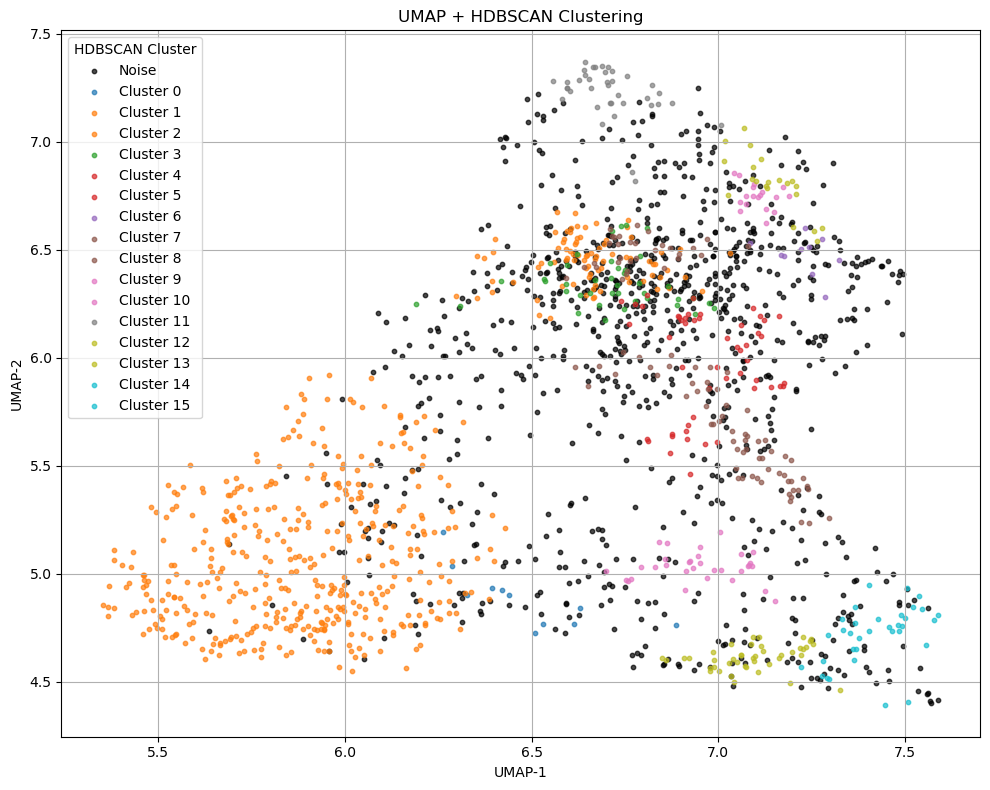

In [15]:
import os
import glob
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 1. Load image paths and assign folder labels
base_dir = "/home/alexander/bueschelquinare_preprocessed/obverse"
image_paths = glob.glob(f"{base_dir}/*/*.png")

labels = []
features = []

# 2. Preprocessing and model setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove classifier
model.eval().to(device)

# 3. Feature extraction loop
for path in image_paths:
    try:
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(x).squeeze().cpu().numpy()  # 512D

        features.append(feat)

        # Extract label (A, B, C, etc.) from folder
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)

    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)

# 4. UMAP reduction
reducer = umap.UMAP(n_components=20, random_state=42)
features_umap = reducer.fit_transform(features)

# 5. HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdb_labels = clusterer.fit_predict(features_umap)

# 6. Evaluation
valid = hdb_labels >= 0
if np.any(valid):
    score = silhouette_score(features_umap[valid], hdb_labels[valid])
    print("HDBSCAN Silhouette Score (valid points only):", score)
else:
    print("No valid clusters found to compute Silhouette Score.")

# 7. Visualization
plt.figure(figsize=(10, 8))
unique_labels = np.unique(hdb_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    idxs = hdb_labels == label
    color = 'black' if label == -1 else colors[i % len(colors)]
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    plt.scatter(features_umap[idxs, 0], features_umap[idxs, 1],
                s=10, c=[color], label=label_name, alpha=0.7)

plt.title("UMAP + HDBSCAN Clustering")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="HDBSCAN Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()



In [17]:
features_umap[0]

array([6.39598  , 6.1512585, 8.991883 , 4.8523655, 5.050742 , 5.578488 ,
       5.276618 , 5.9182725, 6.3570156, 2.1761904, 4.4830976, 6.2405314,
       7.5993133, 3.8486555, 3.2352445, 3.5332406, 3.6813018, 5.115907 ,
       4.980077 , 3.6665912], dtype=float32)

In [1]:
import os
import glob
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 1. Load image paths and assign folder labels
base_dir = "/home/alexander/bueschelquinare_preprocessed/obverse"
image_paths = glob.glob(f"{base_dir}/*/*.png")

labels = []
features = []

# 2. Preprocessing and model setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove classifier
model.eval().to(device)

# 3. Feature extraction loop
for path in image_paths:
    try:
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(x).squeeze().cpu().numpy()  # 512D

        features.append(feat)

        # Extract label (A, B, C, etc.) from folder
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)

    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)

# 4. UMAP reduction
reducer = umap.UMAP(n_components=20, random_state=42)
features_umap = reducer.fit_transform(features)


# 6B. (Alternative) Plot by true folder label
# Label encoding
le = LabelEncoder()
label_ids = le.fit_transform(labels)
unique_labels = le.classes_

plt.figure(figsize=(12, 9))
for i, label in enumerate(unique_labels):
    idxs = np.where(label_ids == i)[0]
    plt.scatter(embedding[idxs, 0], embedding[idxs, 1], label=label, s=10)
plt.title("UMAP of ResNet18 Features Colored by Folder Label")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Folder")
plt.grid(True)
plt.tight_layout()
plt.show()

/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 

NameError: name 'LabelEncoder' is not defined

In [6]:
import pandas as pd

df = pd.DataFrame({
    "image_path": image_paths,
    "true_label": labels,
    "cluster": cluster_labels
})

df.to_csv("coin_kmeans_clusters.csv", index=False)

In [7]:
df

,image_path,true_label,cluster
0,/home/alexander/bueschelquinare_preprocessed/o...,H,8
1,/home/alexander/bueschelquinare_preprocessed/o...,H,2
2,/home/alexander/bueschelquinare_preprocessed/o...,H,4
3,/home/alexander/bueschelquinare_preprocessed/o...,H,4
4,/home/alexander/bueschelquinare_preprocessed/o...,H,4
...,...,...,...
1782,/home/alexander/bueschelquinare_preprocessed/o...,undefined,3
1783,/home/alexander/bueschelquinare_preprocessed/o...,undefined,4
1784,/home/alexander/bueschelquinare_preprocessed/o...,undefined,3
1785,/home/alexander/bueschelquinare_preprocessed/o...,undefined,4


In [6]:
import torch
import torch.nn as nn

class CoinAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(CoinAutoencoder, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),  # -> [64, 112, 112]
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # -> [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),  # -> [256*28*28]
            nn.Linear(256 * 28 * 28, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (256, 28, 28)),  # -> [256, 28, 28]
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # -> [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),     # -> [1, 224, 224]
            nn.Sigmoid()  # values in [0,1] range
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent



In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("/home/alexander/bueschelquinare_preprocessed/obverse", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

label_names = dataset.classes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Prot', 'undefined']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Prot', 'undefined']


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CoinAutoencoder(latent_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        recon, _ = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1/20, Loss: 0.0412
Epoch 2/20, Loss: 0.0267
Epoch 3/20, Loss: 0.0221
Epoch 4/20, Loss: 0.0204
Epoch 5/20, Loss: 0.0185
Epoch 6/20, Loss: 0.0164
Epoch 7/20, Loss: 0.0148
Epoch 8/20, Loss: 0.0136
Epoch 9/20, Loss: 0.0127
Epoch 10/20, Loss: 0.0119
Epoch 11/20, Loss: 0.0112
Epoch 12/20, Loss: 0.0106
Epoch 13/20, Loss: 0.0104
Epoch 14/20, Loss: 0.0100
Epoch 15/20, Loss: 0.0096
Epoch 16/20, Loss: 0.0090
Epoch 17/20, Loss: 0.0088
Epoch 18/20, Loss: 0.0085
Epoch 19/20, Loss: 0.0083
Epoch 20/20, Loss: 0.0081


In [9]:
model.eval()
features = []
labels = []

with torch.no_grad():
    for imgs, lbls in dataloader:
        imgs = imgs.to(device)
        _, latent = model(imgs)
        features.extend(latent.cpu().numpy())
        labels.extend(lbls.numpy())


/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


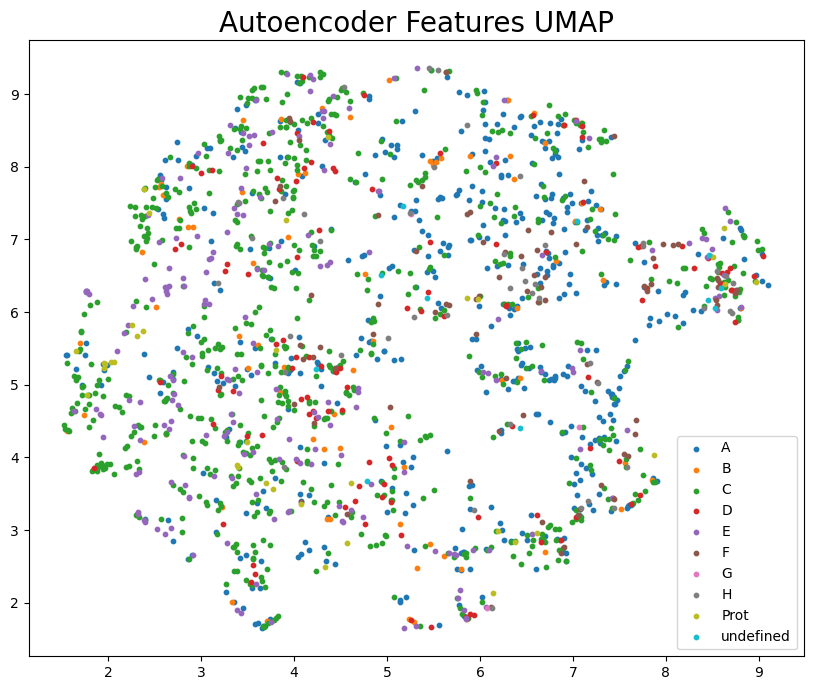

In [19]:
import umap
import matplotlib.pyplot as plt
import numpy as np

features = np.array(features)
labels = np.array(labels)

#reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
reducer = umap.UMAP(n_neighbors=5, min_dist=0.01, metric='cosine')

X_umap = reducer.fit_transform(features)

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_names):
    idxs = labels == i
    plt.scatter(X_umap[idxs, 0], X_umap[idxs, 1], label=class_name, s=10)

plt.title("Autoencoder Features UMAP",fontsize = 20)
# displaying the title
plt.legend()
plt.show()


Running t-SNE...


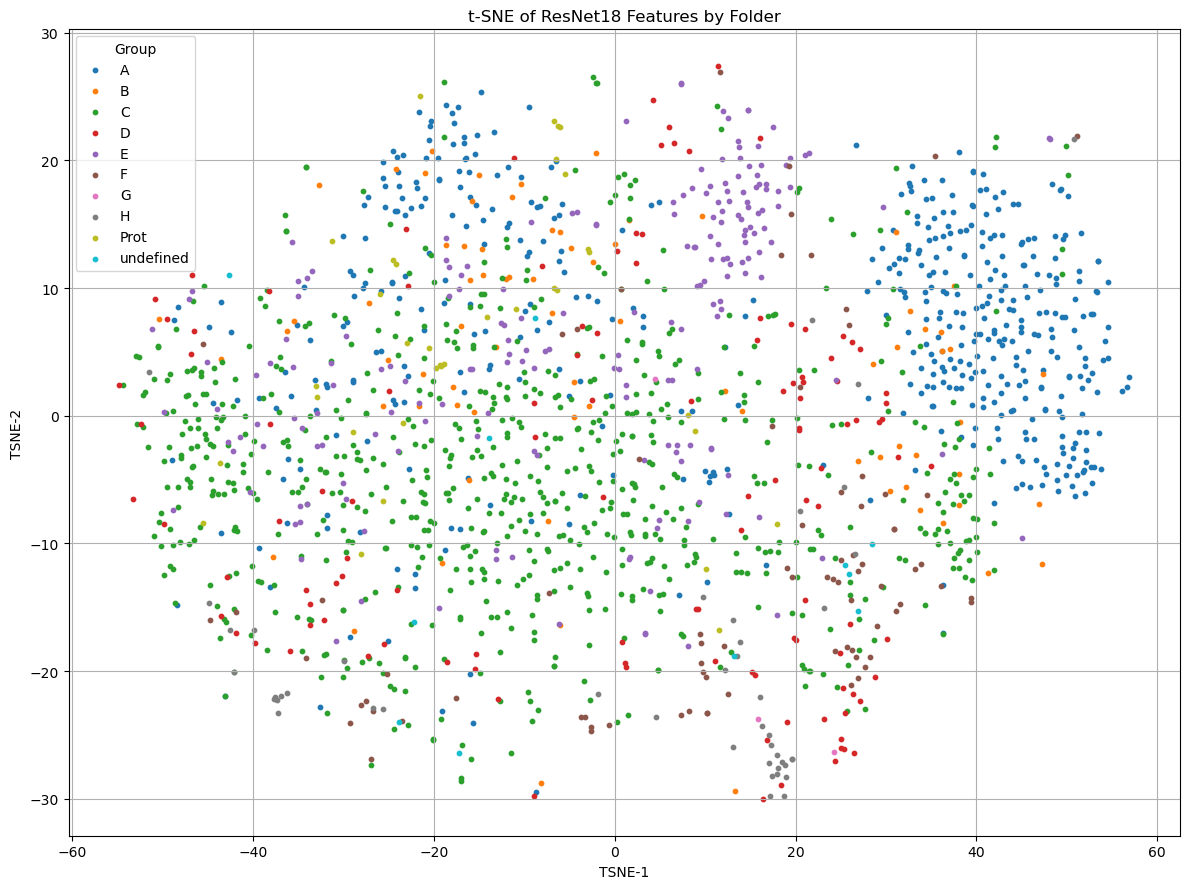

In [5]:
# 4. t-SNE dimensionality reduction
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(features)

# 5. Color mapping
unique_labels = sorted(set(labels))
label_to_color = {label: plt.cm.tab10(i % 10) for i, label in enumerate(unique_labels)}
colors = [label_to_color[label] for label in labels]

# 6. Plotting
plt.figure(figsize=(12, 9))
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], s=10, label=label, color=label_to_color[label])

plt.title("t-SNE of ResNet18 Features by Folder")
plt.legend(title="Group")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.tight_layout()
plt.show()

Running UMAP...


/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


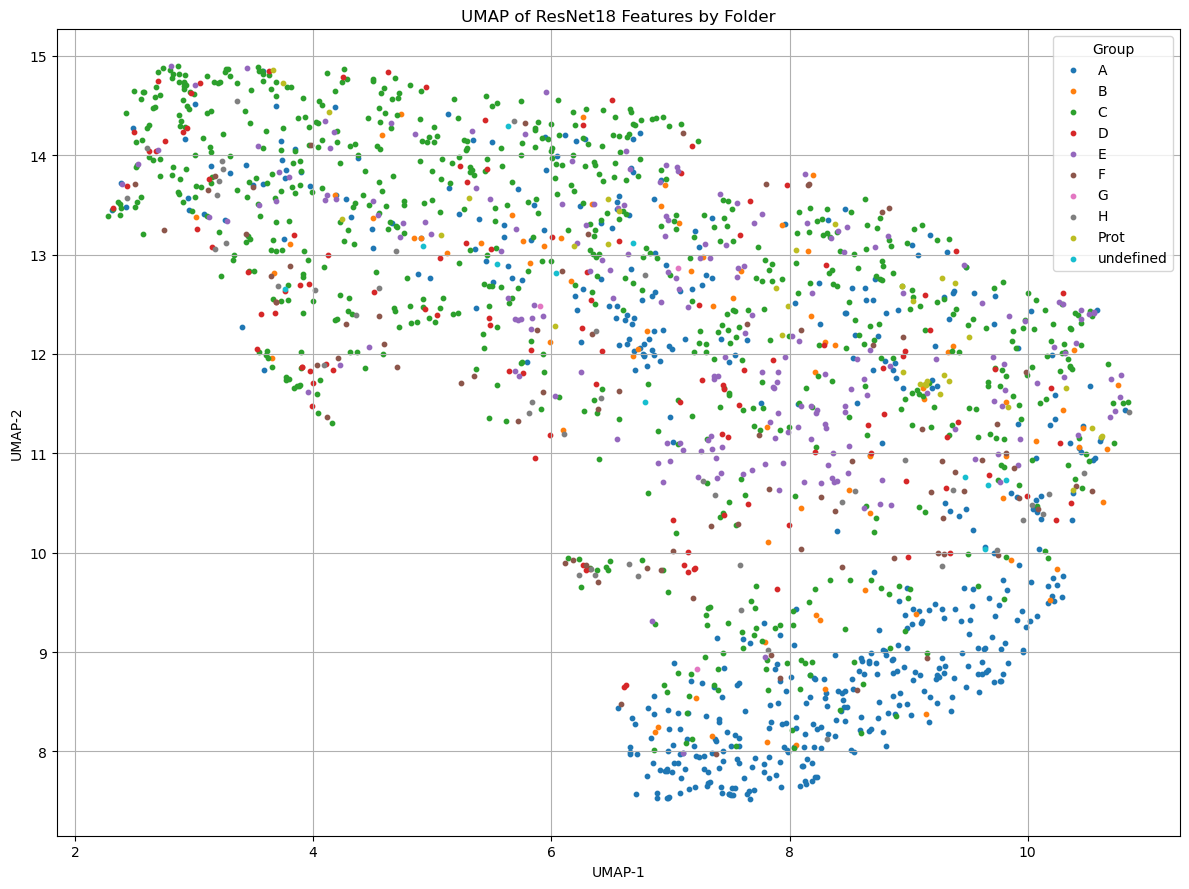

In [5]:
print("Running UMAP...")
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(features)

# 5. Color mapping
unique_labels = sorted(set(labels))
label_to_color = {label: plt.cm.tab10(i % 10) for i, label in enumerate(unique_labels)}
colors = [label_to_color[label] for label in labels]

plt.figure(figsize=(12, 9))
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_umap[idxs, 0], X_umap[idxs, 1], s=10, label=label, color=label_to_color[label])

plt.title("UMAP of ResNet18 Features by Folder")
plt.legend(title="Group")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


Running 3D UMAP...


/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



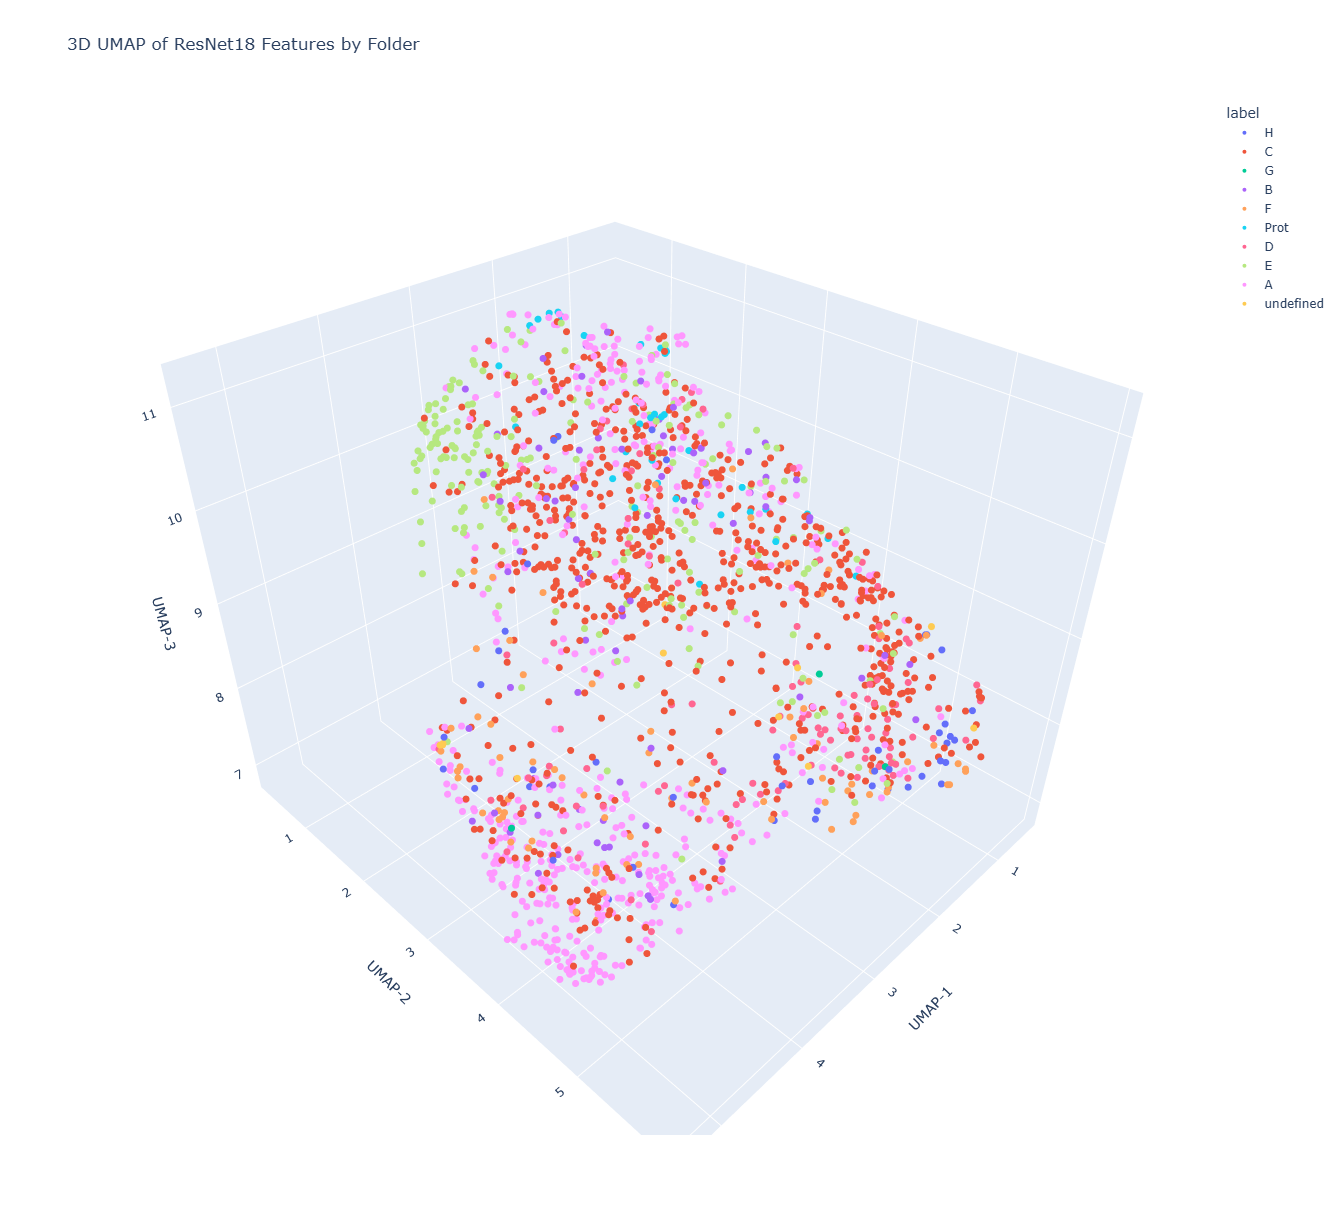

In [6]:
import plotly.express as px
import umap

print("Running 3D UMAP...")
umap_model_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_umap_3d = umap_model_3d.fit_transform(features)

# Create a dataframe for Plotly
import pandas as pd
df = pd.DataFrame({
    'UMAP-1': X_umap_3d[:, 0],
    'UMAP-2': X_umap_3d[:, 1],
    'UMAP-3': X_umap_3d[:, 2],
    'label': labels
})

fig = px.scatter_3d(
    df, x='UMAP-1', y='UMAP-2', z='UMAP-3',
    color='label',
    title="3D UMAP of ResNet18 Features by Folder",
    width=1500, height=1200
)
fig.update_traces(marker=dict(size=4))

fig.show()
